# Step 2. Data Preparation

---

This step includes both data cleaning and data processing. The resulting data is **split 80/20** into a train and a test set and saved into `./data/train` and `./data/test`  folders under the same class-separated folder structure as the raw dataset.

For both train and test datasets, we will:

1. Augment Identical Images (Data Duplication). Method: Comparing `imagehash.average_hash()` of each image to get the identical images, then randomly rotate and flip them.
2. Remove Transparency and Grayscale: Convert images of all other modes to `RGB`, excluding `L` images (grayscale).
3. Standardize Sizes and Aspect Ratios: [`utils.glob.TARGET_IMG_SIZE`](../utils/glob.py) width and height, 1:1 aspect ratio.
4. Normalize Pixel Values: common scale: [0, 1].
5. Quality Control: Manual inspection of a subset of images to ensure overall dataset quality.


In [1]:
# Imports and environmental setups

import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import imagehash
from PIL import Image
from sklearn.model_selection import train_test_split


# Custom utils functions
from utils import dataset
from utils.visualization import data_countplot
from utils.visualization import data_histplot
from utils.visualization import data_plot_16samples
from utils.glob import TARGET_IMG_SIZE


plt.style.use('ggplot')
dir_raw_dataset = '../data/raw/'
dir_train_dataset = '../data/train/'
dir_test_dataset = '../data/test/'

## Load Raw Dataset

Using our custom `dataset.load()` function.

In [2]:
df_raw = dataset.load(dir_raw_dataset)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16362 entries, 0 to 16361
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       16362 non-null  object 
 1   FileType      16362 non-null  object 
 2   Width         16362 non-null  int64  
 3   Height        16362 non-null  int64  
 4   Ratio         16362 non-null  float64
 5   Mode          16362 non-null  object 
 6   Bands         16362 non-null  object 
 7   Transparency  16362 non-null  bool   
 8   Animated      16362 non-null  bool   
 9   Class         16362 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 1.0+ MB


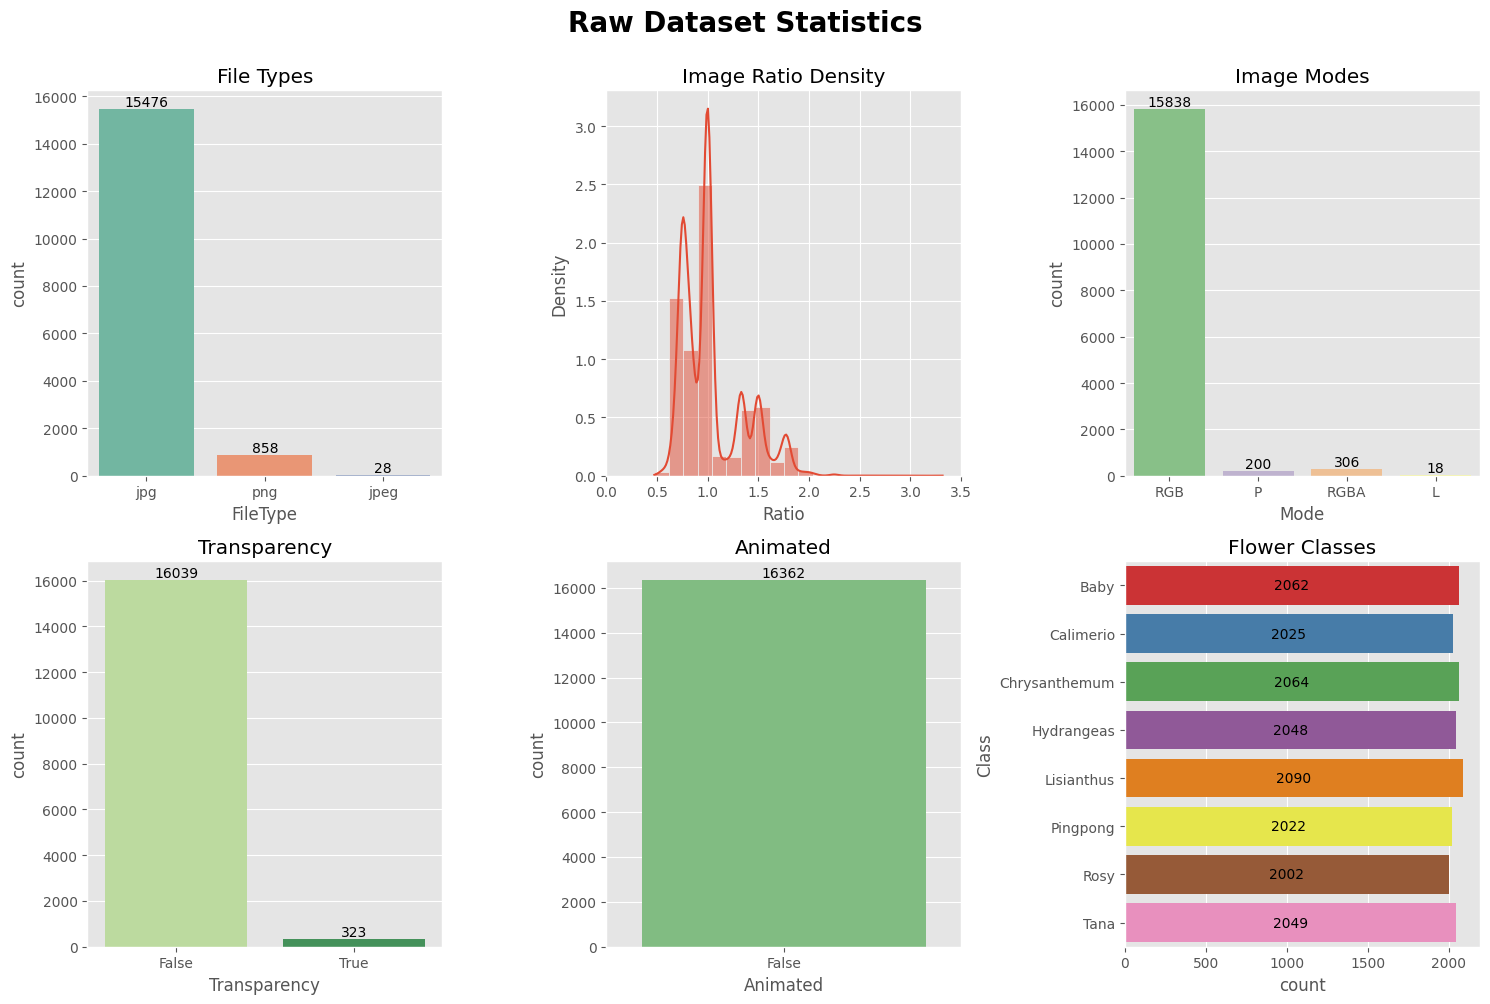

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

data_countplot(df_raw, 'FileType', ax=ax[0][0], title='File Types', annotate=True, palette='Set2')
data_histplot(df_raw, 'Ratio', ax=ax[0][1], title='Image Ratio Density', bins=20, kde=True, stat='density')
data_countplot(df_raw, 'Mode', ax=ax[0][2], title='Image Modes', annotate=True, palette='Accent')
data_countplot(df_raw, 'Transparency', ax=ax[1][0], title='Transparency', annotate=True, palette='YlGn')
data_countplot(df_raw, 'Animated', ax=ax[1][1], title='Animated', annotate=True, palette='YlGn')
data_countplot(df_raw, 'Class', ax=ax[1][2], horizontal=True, title='Flower Classes', xticklabels_rotation=45, annotate=True, palette='Set1')

fig.suptitle('Raw Dataset Statistics', fontsize=20, fontweight='bold', y=1.0)
fig.tight_layout()

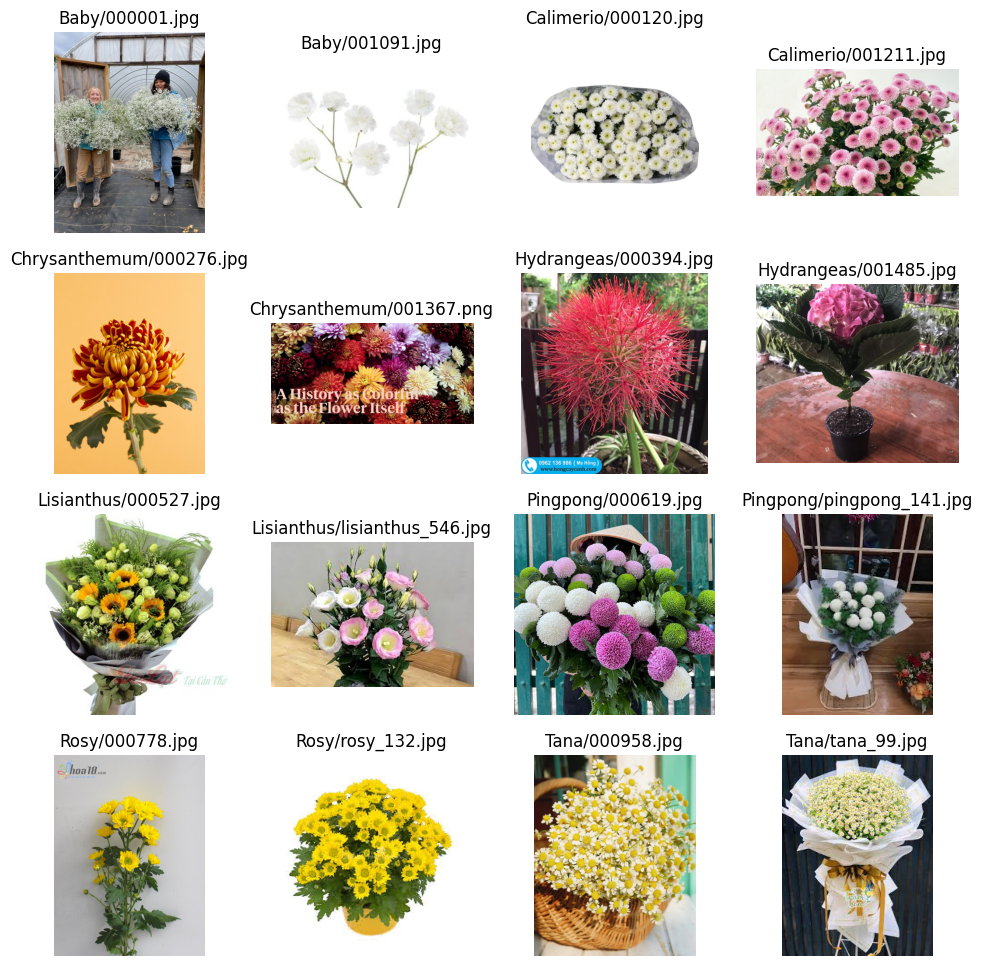

In [4]:
data_plot_16samples(dir_raw_dataset, df_raw)

## 2.1. Data Cleaning and Processing

### 2.1.1. Identical Images (Duplicated Data) Cleaning

We are detecting all identical images and store them in a list `duplicated_image_hashes` (skipping the first copy) so that we can access them later for augmentation and saving them into our processed train and test dataset in `./data/train/` and `./data/test/`:

In [5]:
image_hashes = {}
for i, row in df_raw.iterrows():
    with Image.open(f'{dir_raw_dataset}{row["ImgPath"]}') as im:
        image_hash = imagehash.average_hash(im, hash_size=8)
        if image_hash in image_hashes:
            image_hashes[image_hash].append(row["ImgPath"])
        else:
            image_hashes[image_hash] = [row["ImgPath"]]

duplicated_image_hashes = {hash_val: paths for hash_val, paths in image_hashes.items() if len(paths) > 1}  # Remove hashes with a single path

duplicated_images_paths = []
for paths in duplicated_image_hashes.values():
    for i, path in enumerate(paths):
        if i > 0:  # Skipping the first copy
            duplicated_images_paths.append(path)

C:\Users\vomin\Projects\rmit\cosc2753\rmit2023a-cosc2753-assignment2\venv\Lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
print(f'Number of duplicated images: {len(duplicated_images_paths)}')

Number of duplicated images: 11676


### 2.1.3. Further Cleaning and Processing

1. Split raw dataset into train and test sets
2. For both train and test set:
    - Augment Identical Images
    - Remove Transparency and Grayscale
    - Standardize Sizes and Aspect Ratios
    - Normalize Pixel Values


In [7]:
def augment(image: Image, seed: int = None) -> Image:
    if seed is not None:
        random.seed(seed)

    # Rotation
    rotation_angle = random.randint(-180, 180)
    rotated_image = image.rotate(rotation_angle, expand=True)

    # Cropping non-image area after rotation. For the math, see: https://stackoverflow.com/questions/21346670/cropping-rotated-image-with-same-aspect-ratio
    aspect_ratio = image.size[0] / image.size[1]
    rotated_aspect_ratio = rotated_image.size[0] / rotated_image.size[1]
    angle = math.fabs(rotation_angle) * math.pi / 180

    if aspect_ratio < 1:
        total_height = float(image.size[0]) / rotated_aspect_ratio
    else:
        total_height = float(image.size[1])

    h = total_height / (aspect_ratio * math.fabs(math.sin(angle)) + math.fabs(math.cos(angle)))
    w = h * aspect_ratio

    left = (rotated_image.size[0] - w) / 2
    upper = (rotated_image.size[1] - h) / 2
    right = left + w
    lower = upper + h
    cropped_image = rotated_image.crop((left, upper, right, lower))


    # Horizontal flipping
    flip_prob = random.random()
    if flip_prob < 0.5:
        flipped_image = cropped_image.transpose(Image.FLIP_LEFT_RIGHT)
    else:
        flipped_image = cropped_image

    # Vertical flipping
    flip_prob = random.random()
    if flip_prob < 0.5:
        flipped_image = flipped_image.transpose(Image.FLIP_TOP_BOTTOM)


    return flipped_image

In [8]:
def remove_transparency(image: Image) -> Image:
    if im.mode in ('RGBA', 'RGBa', 'LA', 'La', 'PA', 'P'):
        if image.mode != 'RGBA':
            image = image.convert('RGBA')
        image = image.convert('RGB')
    return image

In [9]:
def resize_crop(image: Image, width: int, height: int) -> Image:
    original_aspect_ratio = image.width / image.height
    target_aspect_ratio = width / height

    if original_aspect_ratio > target_aspect_ratio:
        # Crop horizontally
        new_width = int(image.height * target_aspect_ratio)
        left = (image.width - new_width) // 2
        upper = 0
        right = left + new_width
        lower = image.height
    else:
        # Crop vertically
        new_height = int(image.width / target_aspect_ratio)
        left = 0
        upper = (image.height - new_height) // 2
        right = image.width
        lower = upper + new_height

    cropped_image = image.crop((left, upper, right, lower))
    resized_image = cropped_image.resize((width, height), Image.Resampling.LANCZOS)

    return resized_image

In [10]:
def normalize_pixels(image: Image) -> Image:
    image_array = np.array(image)
    normalized_image_array = image_array / 255.0  # Normalize pixel values to the range [0, 1]
    return Image.fromarray((normalized_image_array * 255).astype(np.uint8))

In [11]:
train, test = train_test_split(df_raw, shuffle=True, test_size=0.2, random_state=42)

# Train set
for i, row in train.iterrows():
    if not os.path.exists(f'{dir_train_dataset}{row["Class"]}'):
        os.makedirs(f'{dir_train_dataset}{row["Class"]}')

    img_path = row['ImgPath']
    new_img_path = ''.join(img_path.split('.')[0:-1]) + '.jpg'
    with Image.open(f'{dir_raw_dataset}{img_path}') as im:
        if im.mode == 'L':
            continue  # Ignoring grayscale images

        if img_path in duplicated_images_paths:
            im = augment(im, seed=42)
        im = remove_transparency(im)
        im = resize_crop(im, TARGET_IMG_SIZE, TARGET_IMG_SIZE)
        im = normalize_pixels(im)

        im.save(f'{dir_train_dataset}{new_img_path}')

# Test set
for i, row in test.iterrows():
    if not os.path.exists(f'{dir_test_dataset}{row["Class"]}'):
        os.makedirs(f'{dir_test_dataset}{row["Class"]}')

    img_path = row['ImgPath']
    new_img_path = ''.join(img_path.split('.')[0:-1]) + '.jpg'
    with Image.open(f'{dir_raw_dataset}{img_path}') as im:
        if im.mode == 'L':
            continue  # Ignoring grayscale images

        if img_path in duplicated_images_paths:
            im = augment(im, seed=42)
        im = remove_transparency(im)
        im = resize_crop(im, TARGET_IMG_SIZE, TARGET_IMG_SIZE)
        im = normalize_pixels(im)

        im.save(f'{dir_test_dataset}{new_img_path}')

## 2.2. Quality Control

### 2.2.1. Train Dataset

In [12]:
df_train = dataset.load(dir_train_dataset)

In [13]:
df_train.describe()

Width   Height    Ratio
count  13073.0  13073.0  13073.0
mean     512.0    512.0      1.0
std        0.0      0.0      0.0
min      512.0    512.0      1.0
25%      512.0    512.0      1.0
50%      512.0    512.0      1.0
75%      512.0    512.0      1.0
max      512.0    512.0      1.0

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13073 entries, 0 to 13072
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       13073 non-null  object 
 1   FileType      13073 non-null  object 
 2   Width         13073 non-null  int64  
 3   Height        13073 non-null  int64  
 4   Ratio         13073 non-null  float64
 5   Mode          13073 non-null  object 
 6   Bands         13073 non-null  object 
 7   Transparency  13073 non-null  bool   
 8   Animated      13073 non-null  bool   
 9   Class         13073 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 842.7+ KB


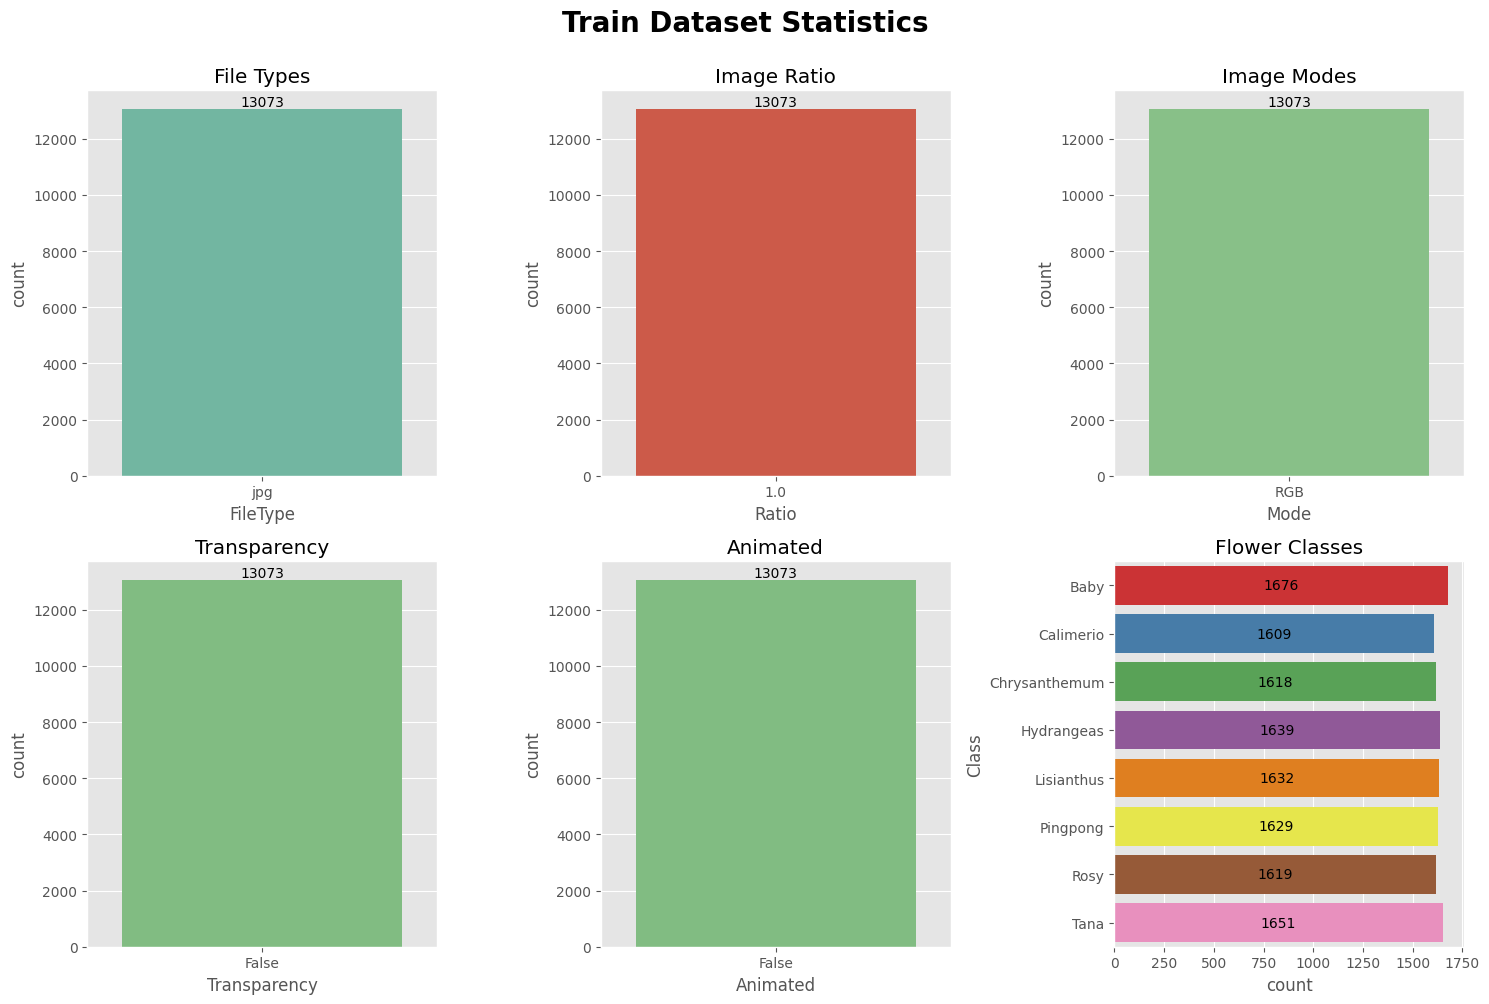

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

data_countplot(df_train, 'FileType', ax=ax[0][0], title='File Types', annotate=True, palette='Set2')
data_countplot(df_train, 'Ratio', ax=ax[0][1], title='Image Ratio', annotate=True)
data_countplot(df_train, 'Mode', ax=ax[0][2], title='Image Modes', annotate=True, palette='Accent')
data_countplot(df_train, 'Transparency', ax=ax[1][0], title='Transparency', annotate=True, palette='YlGn')
data_countplot(df_train, 'Animated', ax=ax[1][1], title='Animated', annotate=True, palette='YlGn')
data_countplot(df_train, 'Class', ax=ax[1][2], horizontal=True, title='Flower Classes', xticklabels_rotation=45, annotate=True, palette='Set1')

fig.suptitle('Train Dataset Statistics', fontsize=20, fontweight='bold', y=1.0)
fig.tight_layout()

fig.savefig('images/DataPrep-TrainDataset-Stats.png')

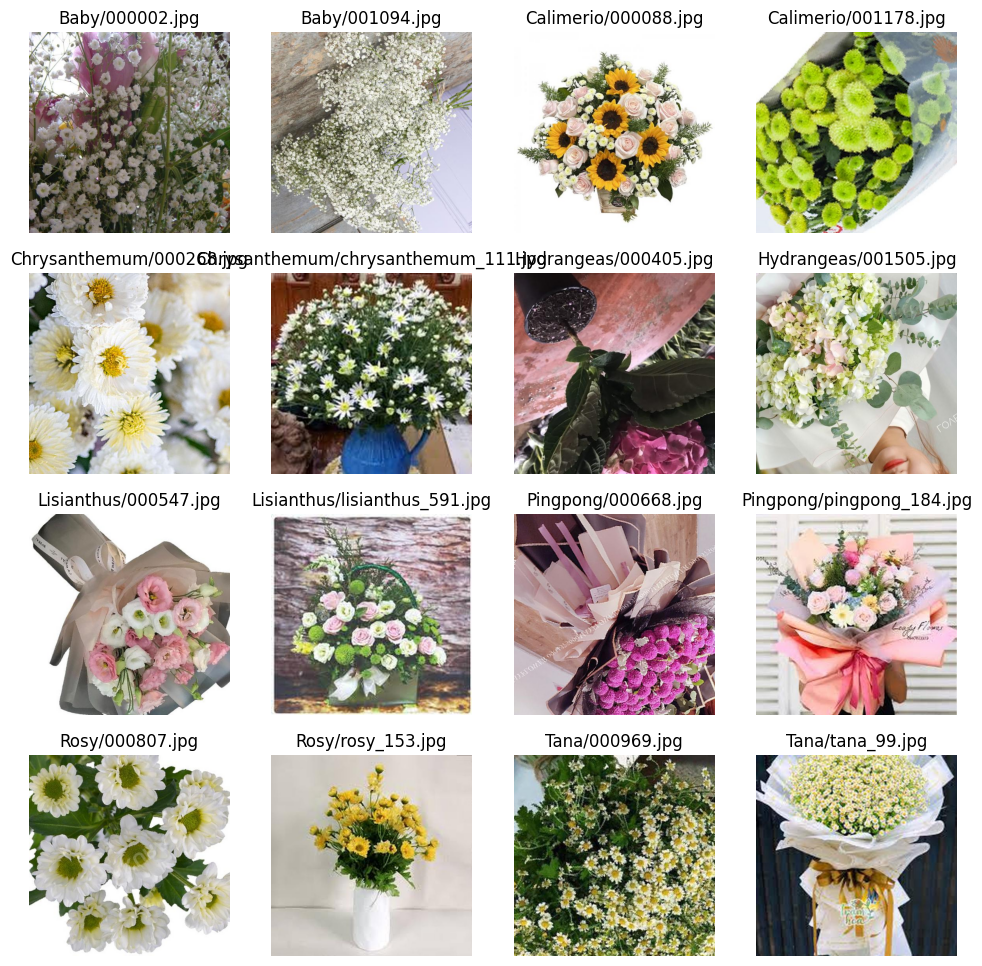

In [16]:
data_plot_16samples(dir_train_dataset, df_train, to_file='images/DataPrep-TrainDataset-16Samples.png')

### 2.2.2. Test Dataset

In [17]:
df_test = dataset.load(dir_test_dataset)

In [18]:
df_test.describe()

Width  Height   Ratio
count  3271.0  3271.0  3271.0
mean    512.0   512.0     1.0
std       0.0     0.0     0.0
min     512.0   512.0     1.0
25%     512.0   512.0     1.0
50%     512.0   512.0     1.0
75%     512.0   512.0     1.0
max     512.0   512.0     1.0

In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       3271 non-null   object 
 1   FileType      3271 non-null   object 
 2   Width         3271 non-null   int64  
 3   Height        3271 non-null   int64  
 4   Ratio         3271 non-null   float64
 5   Mode          3271 non-null   object 
 6   Bands         3271 non-null   object 
 7   Transparency  3271 non-null   bool   
 8   Animated      3271 non-null   bool   
 9   Class         3271 non-null   object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 211.0+ KB


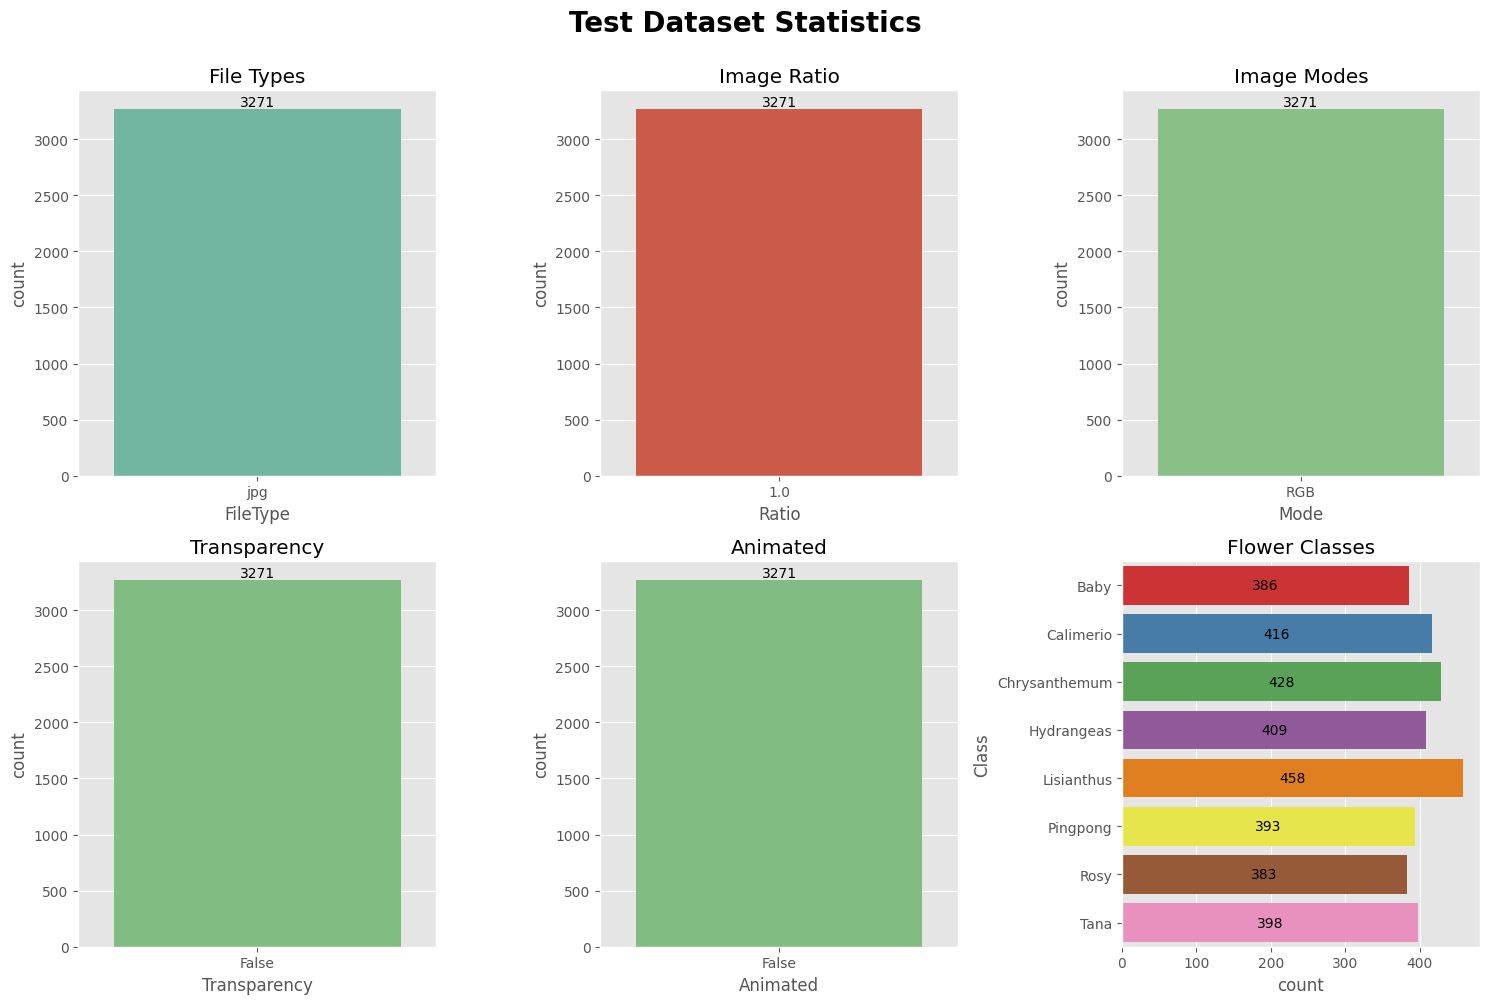

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

data_countplot(df_test, 'FileType', ax=ax[0][0], title='File Types', annotate=True, palette='Set2')
data_countplot(df_test, 'Ratio', ax=ax[0][1], title='Image Ratio', annotate=True)
data_countplot(df_test, 'Mode', ax=ax[0][2], title='Image Modes', annotate=True, palette='Accent')
data_countplot(df_test, 'Transparency', ax=ax[1][0], title='Transparency', annotate=True, palette='YlGn')
data_countplot(df_test, 'Animated', ax=ax[1][1], title='Animated', annotate=True, palette='YlGn')
data_countplot(df_test, 'Class', ax=ax[1][2], horizontal=True, title='Flower Classes', xticklabels_rotation=45, annotate=True, palette='Set1')

fig.suptitle('Test Dataset Statistics', fontsize=20, fontweight='bold', y=1.0)
fig.tight_layout()

fig.savefig('images/DataPrep-TestDataset-Stats.png')

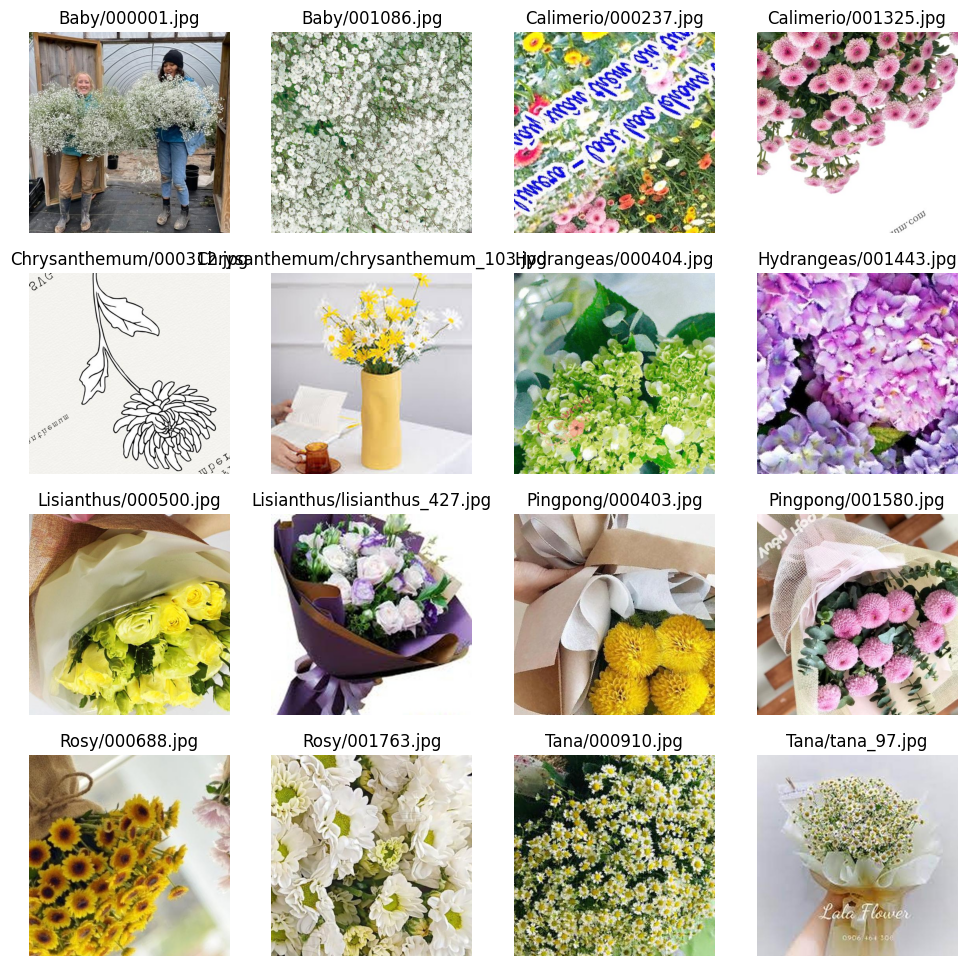

In [21]:
data_plot_16samples(dir_test_dataset, df_test, to_file='images/DataPrep-TestDataset-16Samples.png')

## 2.3. ☞ Final Observation

We have successfully cleaned and processed our dataset while minimally affecting our class distribution by using the techniques mentioned above. We also did not affect our dataset negatively in any other way. The processed data is stored in `./data/train/` and `./data/test` for train and test datasets, respectively.

For further enhancement to our dataset in the future, we may try:

1. Remove Outliers:
    - Identify and remove outlier images that do not represent the desired classes or introduce noise into the dataset.
2. Noise Removal:
    - Apply noise removal techniques to clean up images with noise, artifacts, or irrelevant elements.

For now, we are not pursuing these due to our time constraint, since they are very time-consuming to implement (Remove Outliers) or not needed for our the image quality that we have (Noise Removal), and we are not sure if their effect on our models' performance is worth the time investment.